In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from scipy import stats
import pandas as pd
from numpy.random import seed
import numpy as np

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk",font_scale=0.75)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **Interpretation of covariates**
## Consider the following simulated experiment:  

Assume a stimulus elicits a mean response of 1.96 in __roi1__, 0 in __roi2__ and -1.96 in __roi3__.

$$\mu_{roi1} \sim N(1.96,1)$$
$$\mu_{roi2} \sim N(-1.96,1)$$
$$\mu_{roi3} \sim N(0.96,1)$$

In [3]:
mean_ROI1 = 1.96
mean_ROI2 = -1.96
mean_ROI3 = 0

Lets say we collected data on 50 participants (total 150 observation). 

We also collected a behavioral measure from each participant. Call it __anxiety__ score (any arbitrary unit).  
__Anxiety__ is simulated as:
$$anxiety \sim N(0,1)$$

In [4]:
seed(47)
anxiety = stats.norm.rvs(loc = 0, scale=1, size=50)

## Simulation of response (y)

We will make __anxiety__ have a positive relationship with __roi1__, such that a unit increase in __anxiety__ is associated with a unit increase in __roi1__ response (i.e., slope of 1).  

Similarly, we will make __anxiety__ have a negative relationship with __roi2__, such that a unit increase in __anxiety__ is associated with a unit decrease in __roi2__ response (i.e., slope of -1).

Lastly, we will make __roi3__ have no relationship with __anxiety__ (i.e., slope of 0). 

Following three equations are used to simulate response for each roi:  

$$y_{roi1[i]} = \mu_{roi1,[i]} + 1*anxiety_{[i]}$$
$$y_{roi2[i]} = \mu_{roi2,[i]} -1*anxiety_{[i]}$$
$$y_{roi3[i]} = \mu_{roi3,[i]}$$

In [5]:
# Genarate the data using the equations above
df = pd.DataFrame()
for score in anxiety:
    roi1 = stats.norm.rvs(loc=mean_ROI1,scale=1,size=1)[0] + 1*score
    roi2 = stats.norm.rvs(loc=mean_ROI2,scale=1,size=1)[0] + -1*score
    roi3 = stats.norm.rvs(loc=mean_ROI3,scale=1,size=1)[0]
    
    tmp_df = pd.DataFrame({'y':[roi1,roi2,roi3],'ROI':['roi1','roi2','roi3'],'anxiety':[score]*3})
    df = pd.concat([df,tmp_df],axis=0,ignore_index=True)
    
print('Simulated data:')
print(df.head())

Simulated data:
          y   ROI   anxiety
0  1.386114  roi1 -0.848009
1 -0.744694  roi2 -0.848009
2  0.195889  roi3 -0.848009
3  3.152378  roi1  1.305906
4 -5.354833  roi2  1.305906


## Model 1: Only varying intercepts
lme4-like notation:
    $$y = 1 + anxiety + (1 | ROI)$$
    
Full model (in the notation of McElreath 2020):

$$y = \alpha_{0} + \alpha_{ROI} + \beta_{anxiety}*anxiety + \epsilon$$

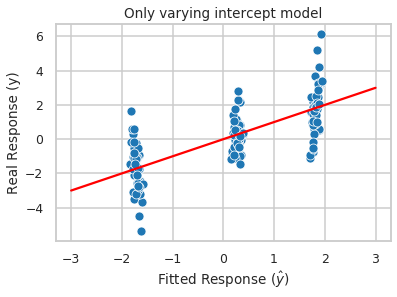

In [6]:
# without covariate
model1 = smf.mixedlm(formula='y ~ anxiety',data=df,groups=df["ROI"]).fit()
sns.scatterplot(model1.fittedvalues,df.y)
plt.plot([-3, 3], [-3, 3], c = "red")
_=plt.xlabel(r'Fitted Response ($\hat{y}$)')
_=plt.ylabel('Real Response (y)')
_=plt.title('Only varying intercept model')

Since ROIs were only allowed to have individual intercepts, the model estimated only mean response for each ROI.

## Model 2: Varying intercepts and varying slopes
lme4-like notation:
    $$y = 1 + anxiety + (1 + anxiety | ROI)$$
    
Full model (in the notation of McElreath 2020):

$$y = \alpha_{0} + \alpha_{ROI} + (\beta_{anxiety}+\beta_{ROI_{anxiety}})*anxiety + \epsilon$$

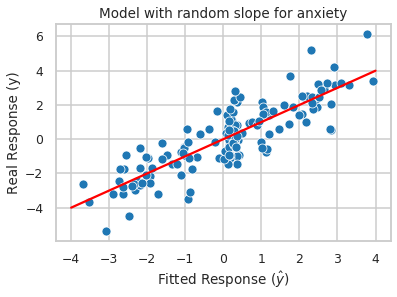

In [7]:
# with covariate
model2 = smf.mixedlm(formula='y ~ anxiety',data=df,groups=df["ROI"],re_formula="anxiety").fit()
sns.scatterplot(model2.fittedvalues,df.y)
plt.plot([-4, 4], [-4, 4], c = "red")
_=plt.xlabel(r'Fitted Response ($\hat{y}$)')
_=plt.ylabel('Real Response (y)')
_=plt.title('Model with random slope for anxiety')

In this model since ROIs were also allowed to have individual slopes (with respect to anxiety), we have been able to achieve a better fit.

In [8]:
re = model2.random_effects
fe = model2.fe_params.to_dict()

In [9]:
# 
estimates = pd.DataFrame()
for roi in ['roi%i' %(i) for i in range(1,4)]:
    intercept = fe['Intercept'] + re[roi]['Group']
    slope = fe['anxiety'] + re[roi]['anxiety']
    estimates = pd.concat([estimates,pd.DataFrame([intercept,slope],index=['Est. Mean Response','Est. Slope for Anxiety'],columns=[roi]).T],ignore_index=False)
    
real = pd.DataFrame({'Real Mean Response':[1.96,-1.96,0],'Real Slope for Anxiety':[1,-1,0]},index=['roi%i' %(i) for i in range(1,4)])

In [10]:
summary = estimates.join(real)
summary.index.name = 'ROI'
summary.reset_index(inplace=True)
summary = summary.melt(id_vars='ROI',var_name='effect',value_name='estimate')

Text(0, 0.5, 'Slope')

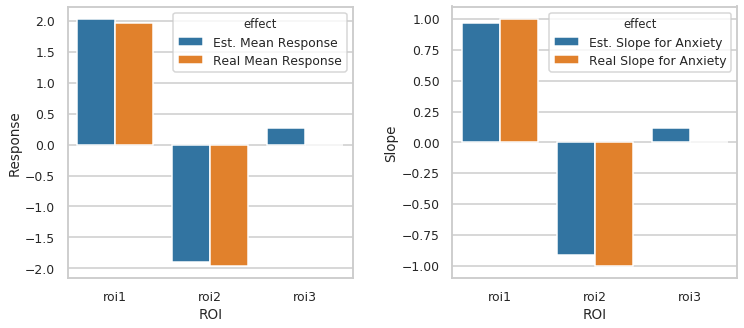

In [11]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=.35)
plt.subplot(1,2,1)
sns.barplot(x='ROI',y='estimate',hue='effect',data=summary[summary['effect'].isin([e for e in summary.effect.unique() if 'Mean' in e])])
plt.ylabel('Response')
plt.subplot(1,2,2)
sns.barplot(x='ROI',y='estimate',hue='effect',data=summary[summary['effect'].isin([e for e in summary.effect.unique() if 'Anxiety' in e])])
plt.ylabel('Slope')

Since we generated the data, we know what the real mean response and anxiety slope is for each ROI. 
Barplots above show real and estimated values; they are very close to each other.

Interpretation of the covariate, anxiety:  

Consider __roi1__. The estimated slope for __roi1__ is around 1 (0.97) (which is what we had contrived it to be during simulation). It means a unit rise in __anxiety__ is associated with an average unit rise in __roi1__ response. Similar interpretations can be drawn about the other two ROIs.

Scatterplots of response vs. anxiety tell the same story. Our slope estimates match with the slopes of the fitted lines.

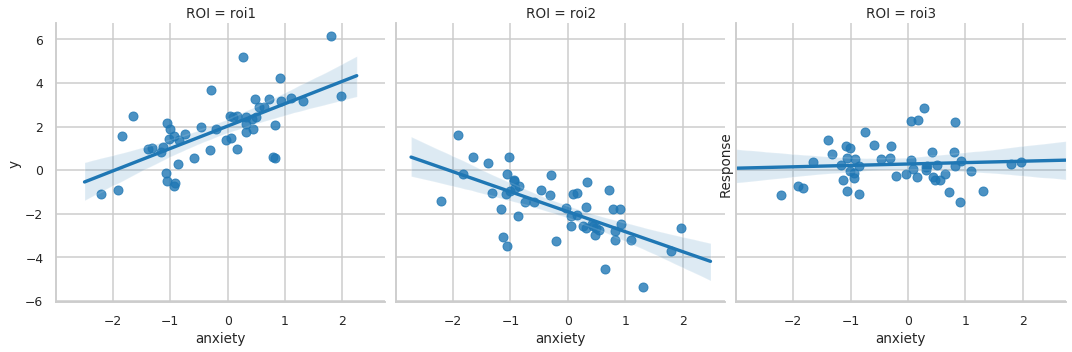

In [12]:
# Lets visualie the simulated data
sns.lmplot(x='anxiety',y='y',data=df,col='ROI')
_=plt.ylabel('Response')